## Setup


In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid", {"axes.grid": False})

## Data Preprocessing


In [3]:
data = pd.read_excel("./data/to_label.xlsx", sheet_name="Sheet1")
data["label"] = data["label"].astype(int)
data.head()

,tweetid,tweet_text,clean_tweet,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,NaN,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,NaN,0
2,1027481525506453504,RT @6FSH1_: مهما ضاق صدرك تذكر أن في ناس توهم ...,RT : مهما ضاق صدرك تذكر أن في ناس توهم بيسجلون...,NaN,0
3,417202038037299200,RT @f450450: ﴿ياحي ياقيوم برحمتك أستغيث أصلح ل...,RT : ﴿ياحي ياقيوم برحمتك أستغيث أصلح لي شأني ك...,NaN,0
4,834074569673736193,RT @7744Qa: بعض البشر ، إذا وجد البديل نكر الج...,RT : بعض البشر ، إذا وجد البديل نكر الجميل. قر...,NaN,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweetid      2100 non-null   int64 
 1   tweet_text   2100 non-null   object
 2   clean_tweet  2100 non-null   object
 3   tech         202 non-null    object
 4   label        2100 non-null   int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 74.0+ KB


In [5]:
label_names = ["transparent", "propaganda"]

In [6]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [7]:
# from sklearn.model_selection import train_test_split
# train, valid = train_test_split(data, test_size=0.25, random_state=42, stratify=data.label)

In [8]:
# len(train), len(valid)

In [9]:
# train.label.value_counts(normalize=True)

In [10]:
w = data.label.value_counts(normalize=True).to_numpy()
w

array([0.90380952, 0.09619048])

In [11]:
# valid.label.value_counts(normalize=True)

In [12]:
# train = train.reset_index(drop=True)
# valid = valid.reset_index(drop=True)

## Tokenization


In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")

In [14]:
# transformimg from pandas to hugging face datasets

from datasets import Dataset, DatasetDict

train = Dataset.from_pandas(data, split="train")
valid = Dataset.from_pandas(data, split="validation")

ds = DatasetDict({"train": train, "validation": valid})

ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'tweet_text', 'clean_tweet', 'tech', 'label'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['tweetid', 'tweet_text', 'clean_tweet', 'tech', 'label'],
        num_rows: 2100
    })
})

In [15]:
def tokenize_ds(field):
    """Tokenize examples from dataset."""
    return tokenizer(field["clean_tweet"], truncation=True)

In [16]:
ds_encoded = ds.map(tokenize_ds, batched=True)

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

In [17]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'tweet_text', 'clean_tweet', 'tech', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['tweetid', 'tweet_text', 'clean_tweet', 'tech', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2100
    })
})

## Modeling


### Setup


In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
def compute_scores(preds):
    """Compute scores of transformers predictions."""
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average="binary")
    prec = precision_score(labels, pred, average="binary")
    rec = recall_score(labels, pred, average="binary")
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv02-twitter",
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

### Training


In [22]:
import torch
from torch import nn

In [23]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
w_ = 1 / w
w_ = w_ / w_.sum()
w_

array([0.09619048, 0.90380952])

In [25]:
w_ = torch.tensor(w_, dtype=torch.float32, device=device)
w_

tensor([0.0962, 0.9038], device='cuda:0')

In [26]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")  # [batch_size, num_labels]
        # del inputs['labels']
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = nn.CrossEntropyLoss(weight=w_)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [27]:
training_args = TrainingArguments(
    output_dir="./models/arabertv2-propaganda",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.0001,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=1,
    warmup_ratio=0.2,
    log_level="error",
    seed=42,
)

In [28]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [30]:
trainer.train()

C:\Users\ehhho\anaconda3\envs\main\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.465900,0.245263,0.867619,0.417031,0.945545,0.578788
2,0.096100,0.153102,0.955714,0.705660,0.925743,0.800857


TrainOutput(global_step=132, training_loss=0.35763292618547426, metrics={'train_runtime': 247.6135, 'train_samples_per_second': 16.962, 'train_steps_per_second': 0.533, 'total_flos': 113518031502000.0, 'train_loss': 0.35763292618547426, 'epoch': 2.0})

In [31]:
# testing the model

test_outs = trainer.predict(ds_encoded["validation"])

test_outs.metrics

{'test_loss': 0.15310196578502655,
 'test_Accuracy': 0.9557142857142857,
 'test_Precision': 0.7056603773584905,
 'test_Recall': 0.9257425742574258,
 'test_F1': 0.8008565310492505,
 'test_runtime': 17.4586,
 'test_samples_per_second': 120.285,
 'test_steps_per_second': 3.78}

In [32]:
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

In [33]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 transparent       0.99      0.96      0.98      1898
  propaganda       0.71      0.93      0.80       202

    accuracy                           0.96      2100
   macro avg       0.85      0.94      0.89      2100
weighted avg       0.96      0.96      0.96      2100



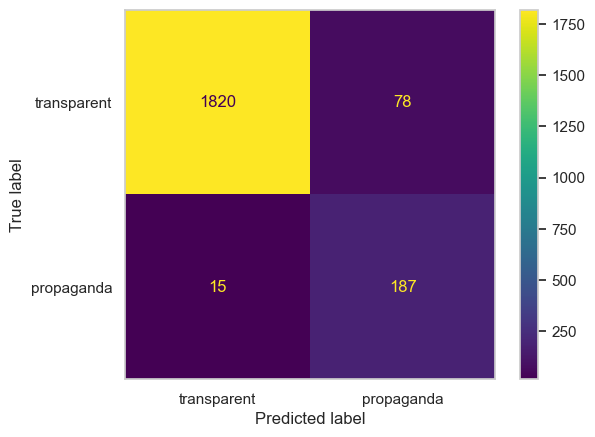

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot()
plt.show()

In [35]:
trainer.save_model("./models/arabertv2-propaganda")